df.isna().sum()
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# Neural Network Class

* A3.3: *Modified `A3grader.tar` to correctly grade the `error_trace` value.  It now assumes you use the following function for the `error_convert_f`:

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

Here are some example uses of your `NeuralNetwork` class.  Your implementation should return very close to the same values in each code cell.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt
import pandas as pd

In [79]:
class NeuralNetwork():

    
    def __init__(self,n_inputs,n_hiddens_list,n_outputs):
        self.n_inputs =n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(self.n_hiddens_list)+1
        self.all_weights , self.Ws,self.all_gradients,self.Gs  = self.make_weights()
        self.initialize_weights()
            
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
    
    def add_ones(self,Xst):
        return np.insert(Xst,0,1,axis=1)  
    
#....................make_weights.............................  
    def make_weights(self):
        self.shapes = np.array([])
        self.shapes = [(1+self.n_inputs,self.n_hiddens_list[0])]
        for i in range(1,len(self.n_hiddens_list)):        
            self.shapes.append((1+self.n_hiddens_list[i-1],self.n_hiddens_list[i]))
            
        self.shapes.append((1+self.n_hiddens_list[-1],self.n_outputs))
        all_weight_shapes = sum(np.prod(self.shapes,axis=1))
        self.all_weights = np.zeros(all_weight_shapes)
        self.all_gradients = np.zeros(all_weight_shapes)
        self.Ws =[]
        self.Gs =[]
        first =0 
        for r,c in self.shapes:
            self.Ws.append(self.all_weights[first: first+(r*c)].reshape(r,c))
            self.Gs.append(self.all_gradients[first: first+(r*c)].reshape(r,c))
            first +=(r*c)

       
        return self.all_weights , self.Ws,self.all_gradients, self.Gs
    
 #....................intialize_weights............................. 
    def initialize_weights(self):
        for k in range(len(self.shapes)):
            self.Ws[k][:] = np.random.uniform(-1, 1, size=(self.shapes[k][0], self.shapes[k][1])) / np.sqrt(self.shapes[k][0])
        return self.all_weights 
    
    
    def calc_standardize_parameters(self,X,T):
        Xmeans=X.mean(axis=0)
        Xstds=X.std(axis=0)

        Tmeans=T.mean(axis=0)
        Tstds=T.std(axis=0)

        self.stand_params= {'Xmeans': Xmeans, 'Xstds': Xstds,
                           'Tmeans': Tmeans, 'Tstds':Tstds}

    def standardize_X(self,X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']


    def unstandardize_X(self,Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']


    def standardize_T(self,T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']


    def unstandardize_T(self,Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def forward(self,Xst):

        self.Yst = [Xst]

   
        for W in self.Ws[:-1]:
            self.Yst.append(np.tanh(self.add_ones(self.Yst[-1]) @ W))

    
        self.Yst.append(self.add_ones(self.Yst[-1]) @ self.Ws[-1])
        self.Yst.pop(0)
        
        return self.Yst

    # Change arguments to replace V, W with Ws
    def backward(self,Xst, Tst):
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]

        output = self.forward(Xst)
        
        output[:0] = [Xst]
        
       
        delta = -2*(Tst - output[-1]) /  (n_samples * n_outputs)

        for layer in range(len(self.Ws) - 1, -1, -1):
#          
            self.Gs[layer][:]=(self.add_ones(output[layer]).T @ delta)
           
            delta = (delta @ self.Ws[layer][1:, :].T) * (1 - output[layer] ** 2)

       
        return self.all_gradients


    def mse(self,Xst, Tst):
        Yst = self.forward(Xst)
        return np.mean((Tst - Yst[-1])**2)

    def train(self,X, T, learning_rate, n_epochs, method,verbose=False):

   

        self.calc_standardize_parameters(X, T)


        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                return np.sqrt(err)
        
        
        Xst = self.standardize_X(X)

        Tst = self.standardize_T(T)

        optimizer = opt.Optimizers(self.all_weights)




        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('method must be ''sgd'', ''adam'', or ''scg''.')

        self.error_trace = optimizer(self.mse, self.backward, [Xst, Tst], learning_rate, n_epochs, error_convert_f=error_convert,verbose=verbose)

    def use(self,X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Yst = self.forward(Xst)
        Yst[-1] = self.unstandardize_T(Yst[-1])
        if(return_hidden_layer_outputs):
            return Yst[-1], Yst[:-1]
        else:
            return Yst[-1]
        


    def get_error_trace(self):
        return self.error_trace
       

In [80]:
np.random.seed(123)
nnet = NeuralNetwork(1, [3], 2)  # 2 outputs
nnet

NeuralNetwork(1, [3], 2)

In [81]:
nnet.all_weights

array([ 0.27784939, -0.30244465, -0.38629038,  0.07257004,  0.31037599,
       -0.10874389,  0.4807642 ,  0.18482974, -0.0190681 , -0.10788248,
       -0.15682198,  0.22904971, -0.06142776, -0.4403221 ])

In [82]:
nnet.Ws

[array([[ 0.27784939, -0.30244465, -0.38629038],
        [ 0.07257004,  0.31037599, -0.10874389]]),
 array([[ 0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248],
        [-0.15682198,  0.22904971],
        [-0.06142776, -0.4403221 ]])]

In [83]:
nnet.all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [84]:
nnet.Gs

[array([[0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [85]:
X = np.linspace(-1, 1, 4).reshape(-1, 1)
X

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ]])

In [86]:
T = np.hstack((X ** 2, (X - 2) ** 3))
T

array([[  1.        , -27.        ],
       [  0.11111111, -12.7037037 ],
       [  0.11111111,  -4.62962963],
       [  1.        ,  -1.        ]])

In [93]:
nnet.train(X, T, 5, 0.01, method='adam',verbose = True)

Adam: Epoch 1 Error=0.99008
Adam: Epoch 2 Error=0.97899
Adam: Epoch 3 Error=0.96800
Adam: Epoch 4 Error=0.95713
Adam: Epoch 5 Error=0.94641


In [94]:
nnet.stand_params

{'Xmeans': array([-5.55111512e-17]),
 'Xstds': array([0.74535599]),
 'Tmeans': array([  0.55555556, -11.33333333]),
 'Tstds': array([0.44444444, 9.98799004])}

In [95]:
nnet.Ws

[array([[ 0.37803807, -0.20314556, -0.28735518],
        [-0.02774094,  0.41056448, -0.20871363]]),
 array([[ 0.38124301,  0.08606188],
        [-0.11893889, -0.20760173],
        [-0.05756948,  0.32899078],
        [ 0.03774468, -0.49877815]])]

In [96]:
nnet.get_error_trace()

[0.9900807825441711,
 0.978989174132703,
 0.9679974639773165,
 0.9571288975924299,
 0.9464063946696561]

In [97]:
nnet.use(X)

array([[  0.72041477, -13.34678898],
       [  0.71156158, -11.50104067],
       [  0.70089165,  -9.45407088],
       [  0.69048016,  -7.49794364]])

In [98]:
Y, Zs = nnet.use(X, return_hidden_layer_outputs=True)
Y, Zs  # Zs is list of hidden layer output matrices

(array([[  0.72041477, -13.34678898],
        [  0.71156158, -11.50104067],
        [  0.70089165,  -9.45407088],
        [  0.69048016,  -7.49794364]]),
 [array([[ 0.39292674, -0.63751476, -0.00733633],
         [ 0.3717431 , -0.36855987, -0.19161733],
         [ 0.35016512, -0.01953305, -0.36331067],
         [ 0.32820898,  0.33432044, -0.51342804]])])

Now here is a function you may use to train a `NeuralNetwork` using a particular method and values for the number of epochs and learning rate.

In [99]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=True)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

sgd: Epoch 400 Error=0.22721
sgd: Epoch 800 Error=0.16875
sgd: Epoch 1200 Error=0.14802
sgd: Epoch 1600 Error=0.13548
sgd: Epoch 2000 Error=0.13208
sgd: Epoch 2400 Error=0.13066
sgd: Epoch 2800 Error=0.12974
sgd: Epoch 3200 Error=0.12915
sgd: Epoch 3600 Error=0.12888
sgd: Epoch 4000 Error=0.12843
Method: sgd, RMSE: Train 0.13 Test 0.28


NeuralNetwork(1, [50, 20, 20], 1)

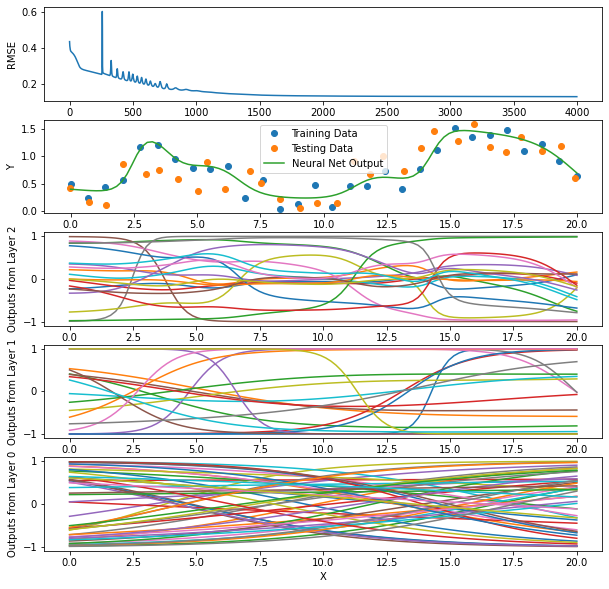

In [100]:
run('sgd', 4000, 0.1)

Adam: Epoch 200 Error=0.18749
Adam: Epoch 400 Error=0.12221
Adam: Epoch 600 Error=0.09956
Adam: Epoch 800 Error=0.08557
Adam: Epoch 1000 Error=0.08227
Adam: Epoch 1200 Error=0.08200
Adam: Epoch 1400 Error=0.08318
Adam: Epoch 1600 Error=0.07989
Adam: Epoch 1800 Error=0.07677
Adam: Epoch 2000 Error=0.07465
Method: adam, RMSE: Train 0.07 Test 0.26


NeuralNetwork(1, [50, 20, 20], 1)

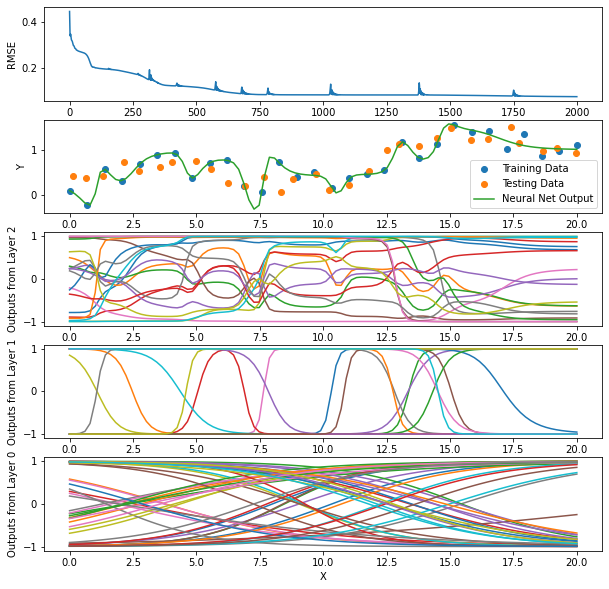

In [101]:
run('adam', 2000, 0.01)

SCG: Epoch 199 Error=0.14571
SCG: Epoch 399 Error=0.06806
SCG: Epoch 599 Error=0.06075
SCG: Epoch 799 Error=0.02098
SCG: Epoch 999 Error=0.01048
SCG: Epoch 1199 Error=0.00483
SCG: Epoch 1399 Error=0.00192
SCG: Epoch 1599 Error=0.00080
SCG: Epoch 1799 Error=0.00004
SCG: Epoch 1999 Error=0.00001
Method: scg, RMSE: Train 0.00 Test 0.31


NeuralNetwork(1, [50, 20, 20], 1)

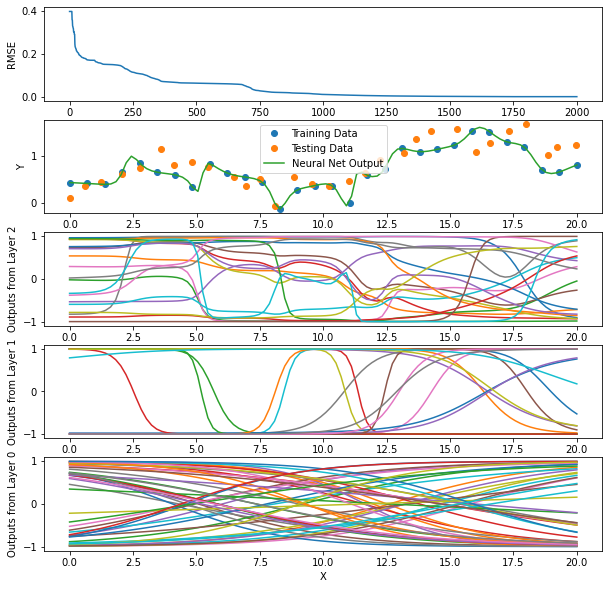

In [102]:
run('scg', 2000)

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_hiddens_list`, `n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

In [103]:
!wc qsar_aquatic_toxicity.csv


  546   546 22903 qsar_aquatic_toxicity.csv


In [104]:
datadf = pd.read_csv('qsar_aquatic_toxicity.csv', delimiter=';', header=None)
datadf

,0,1,2,3,4,5,6,7,8
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


In [105]:
names = ('TPSA', 'SAacc', 'H-050', 'MLOGP', 'RDCHI', 'GATS1p', 'nN', 'C-40', 'LC50')
datadf.columns = names
datadf

,TPSA,SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-40,LC50
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


In [106]:
data = np.loadtxt('qsar_aquatic_toxicity.csv', delimiter=';')
data


array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  3.74 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  4.33 ],
       [ 9.23 , 11.   ,  0.   , ...,  0.   ,  0.   ,  7.019],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  6.219],
       [13.14 ,  9.507,  0.   , ...,  0.   ,  0.   ,  4.995],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  2.48 ]])

In [107]:
data.shape

(546, 9)

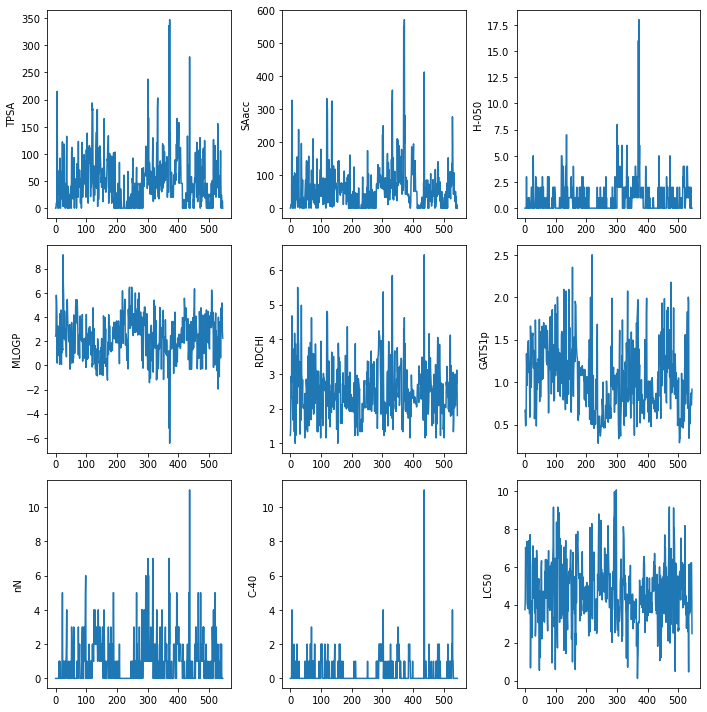

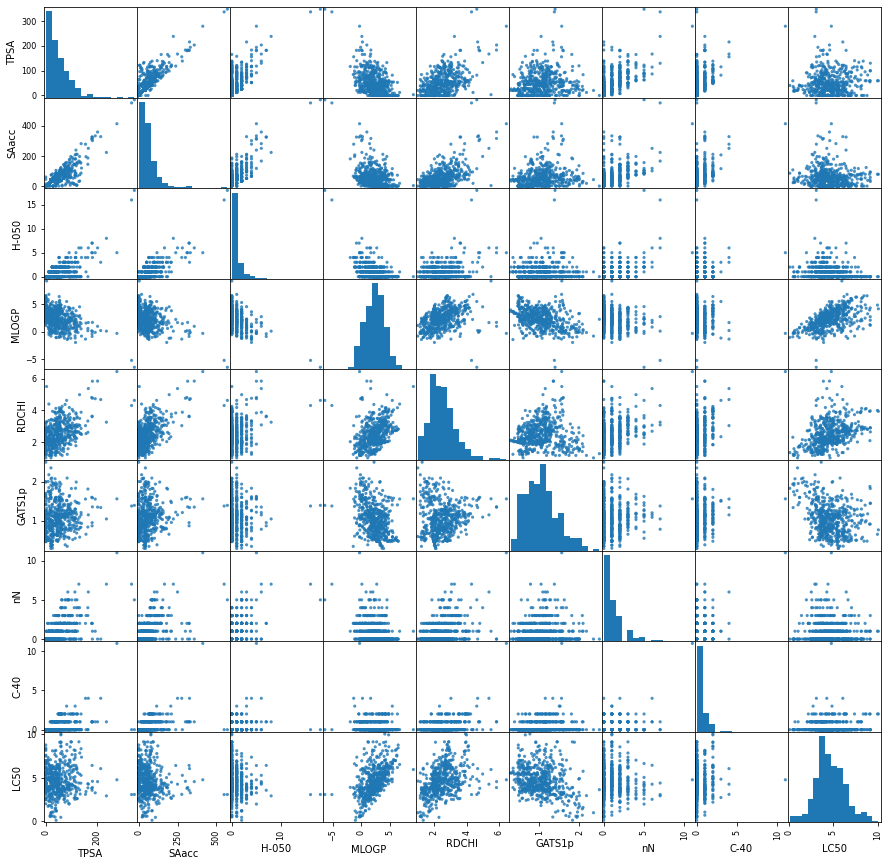

In [108]:
plt.figure(figsize=(10, 10))
for i in range(data.shape[1]):
    plt.subplot(3, 3, i+1)
    plt.plot(data[:, i])
    plt.ylabel(names[i])
plt.tight_layout()

pd.plotting.scatter_matrix(datadf, figsize=(15, 15), marker = 'o', hist_kwds = {'bins': 15}, s = 10, alpha = 0.8);

In [109]:
np.random.shuffle(data)

train_data= data[:500]
test_data = data[500:]


In [110]:
Xtrain = train_data[:, :-1]
Ttrain = train_data[:, -1:]
Xtest = test_data[:, :-1]
Ttest = test_data[:, -1:]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((500, 8), (500, 1), (46, 8), (46, 1))

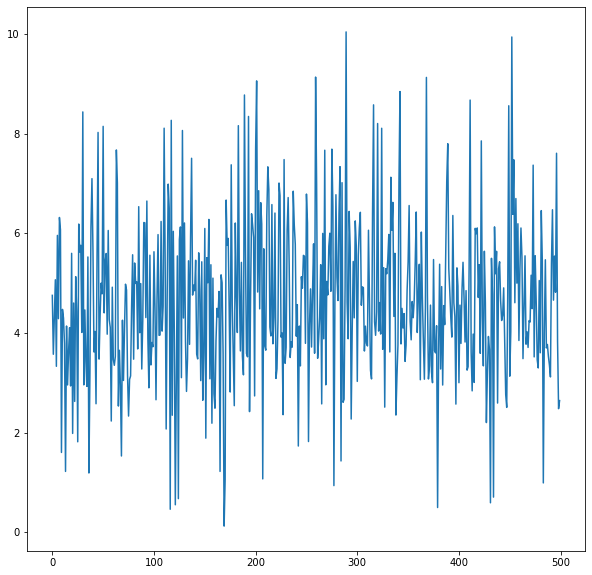

In [111]:
plt.figure(figsize= (10,10))
plt.plot(Ttrain)


In [333]:
def run_data(Xtrain, Ttrain, Xtest, Ttest,n_epochs, n_epochs_per_train, n_hiddens_list,method, learning_rate=None,plot=False):
    
    n_reps = n_epochs // n_epochs_per_train

    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1
        
    n_inputs = Xtrain.shape[1]
    n_hiddens_list = n_hiddens_list
    n_outputs = Ttrain.shape[1]
    
    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    

    rmses = []
    mses = []
    train_accuracy =[] 
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)
        def rmse(Y, T):
            error = T - Y
            return np.sqrt(np.mean(error ** 2))
    
        rmses.append([(reps + 1) * n_epoch,
                      rmse(nnet.use(Xtrain), Ttrain),
                      rmse(nnet.use(Xtest), Ttest)])
        mses.append([(reps+1)*n_epoch,nnet.mse(Xtrain,Ttrain)])

        
    rmses = np.array(rmses)
    mses = np.array(mses)
  
    best_test_index = np.argmin(rmses[:, -1])
    best_test_epoch, best_test_train_rmse, best_test_test_rmse = rmses[best_test_index, :]
    
    if(plot==True):
        
        plt.figure(1, figsize=(15, 15))
        plt.clf()

        n_plot_rows = nnet.n_layers + 1
        ploti = 0



        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(mses[:, 0], mses[:, 1], label='mses')
        plt.xlabel('Epoch')
        plt.ylabel('mses')

        ploti += 1    
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttrain,'o',label='Ttrain')
        plt.plot(nnet.use(Xtrain),label= 'Predicted Test')
        plt.xlabel('Sample Index')
        plt.ylabel('Toxicity')

        ploti += 1    
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttest,'o',label='Ttest')
        plt.plot(nnet.use(Xtest),label= 'Predicted Test')

        plt.xlabel('Sample Index')
        plt.ylabel('Toxicity')

        plt.figure(2)
        plt.plot(rmses[:, 0], rmses[:, 1], label='Train')
        plt.plot(rmses[:, 0], rmses[:, 2], label='Test')
        plt.legend()
        ymin, ymax = plt.ylim()
        plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
        plt.xlabel(f'Epochs')
        plt.ylabel('RMSE')
        
        
        plt.figure(2, figsize=(30, 30))
        plt.clf()

        n_plot_rows2 = nnet.n_layers + 1
        plot2i = 0

        plot2i += 1
        plt.subplot(n_plot_rows2, 1, plot2i)
        plt.plot(nnet.get_error_trace())
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')

        plot2i += 1
        plt.subplot(n_plot_rows2, 1, plot2i)
        plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
        plt.plot(Xtest, Ttest, 'o', label='Testing Data')
        X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
        Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
        plt.plot(X_for_plot, Y, label='Neural Net Output')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')

        for layeri in range(nnet.n_layers - 2, -1, -1):
            plot2i += 1
            plt.subplot(n_plot_rows2, 1, plot2i)
            plt.plot(X_for_plot, Zs[layeri])
            plt.xlabel('X')
            plt.ylabel(f'Outputs from Layer {layeri}')

    else:
        print(f'Best test error is at epoch {best_test_epoch}', end='')
        print(f' with RMSE Train of {best_test_train_rmse:.2f} and Test of {best_test_test_rmse:.2f}')
    
    return nnet,n_epochs,learning_rate,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse

## Test for SGD


In [293]:
results = []
epochs =[500,750,1000]
hidden_list = [[10],[10,10]]
learning_rates =[0.1,0.01,0.001] 
for epoch in epochs:
    for hiddens in hidden_list:
        for learning in learning_rates:
            nnet,n_epochs,learning_rate,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse = run_data(Xtrain, Ttrain,Xtest,Ttest, epoch,20,hiddens,method='sgd',learning_rate=learning)
            results += [(nnet,n_epochs,learning_rate,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse)]
# plt.plot(nnet.get_error_trace())


Best test error is at epoch 80.0 with RMSE Train of 0.91 and Test of 1.24
Best test error is at epoch 280.0 with RMSE Train of 0.99 and Test of 1.38
Best test error is at epoch 500.0 with RMSE Train of 1.13 and Test of 1.49
Best test error is at epoch 140.0 with RMSE Train of 0.75 and Test of 1.24
Best test error is at epoch 500.0 with RMSE Train of 0.87 and Test of 1.37
Best test error is at epoch 500.0 with RMSE Train of 1.12 and Test of 1.48
Best test error is at epoch 40.0 with RMSE Train of 0.93 and Test of 1.31
Best test error is at epoch 680.0 with RMSE Train of 0.93 and Test of 1.35
Best test error is at epoch 380.0 with RMSE Train of 1.09 and Test of 1.45
Best test error is at epoch 20.0 with RMSE Train of 0.96 and Test of 1.35
Best test error is at epoch 280.0 with RMSE Train of 0.94 and Test of 1.42
Best test error is at epoch 380.0 with RMSE Train of 1.05 and Test of 1.35
Best test error is at epoch 200.0 with RMSE Train of 0.79 and Test of 1.44
Best test error is at epoch 

In [294]:
results = np.array(results)
cols =['n_epochs','learning_rate','rmses','mses', 'best_test_epoch', 'best_test_train_rmse', "best_test_test_rmse"] 
results_df = pd.DataFrame(results[:,1:],index = results[:,0],columns=cols)
results_df

,n_epochs,learning_rate,rmses,mses,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10], 1)",500,0.1,"[[20.0, 1.0636712671535629, 1.4121032961287412...","[[20.0, 23.895974810931005], [40.0, 20.4983757...",80,0.912467,1.23672
"NeuralNetwork(8, [10], 1)",500,0.01,"[[20.0, 1.1704378991041744, 1.57083058451021],...","[[20.0, 20.081086441234262], [40.0, 20.5394979...",280,0.990988,1.3812
"NeuralNetwork(8, [10], 1)",500,0.001,"[[20.0, 1.3677663674981515, 1.6395093477935432...","[[20.0, 18.84847066991415], [40.0, 17.39985268...",500,1.12613,1.49348
"NeuralNetwork(8, [10, 10], 1)",500,0.1,"[[20.0, 1.0226028692751075, 1.3422616418025926...","[[20.0, 24.554973382060837], [40.0, 32.7405950...",140,0.749524,1.24224
"NeuralNetwork(8, [10, 10], 1)",500,0.01,"[[20.0, 1.1700282495385634, 1.5390187821321475...","[[20.0, 18.169798767740787], [40.0, 22.8525603...",500,0.869382,1.37169
"NeuralNetwork(8, [10, 10], 1)",500,0.001,"[[20.0, 1.611041273988925, 1.7913357523709443]...","[[20.0, 23.562702065353907], [40.0, 23.2503836...",500,1.12105,1.48225
"NeuralNetwork(8, [10], 1)",750,0.1,"[[20.0, 1.0101706061512667, 1.3751046218902223...","[[20.0, 36.118324484637796], [40.0, 34.7307509...",40,0.934161,1.30794
"NeuralNetwork(8, [10], 1)",750,0.01,"[[20.0, 1.1422814842418394, 1.5150577104136467...","[[20.0, 21.01390665987192], [40.0, 21.83236427...",680,0.92976,1.3486
"NeuralNetwork(8, [10], 1)",750,0.001,"[[20.0, 1.469577115903923, 1.7866312010698293]...","[[20.0, 22.685181521651742], [40.0, 20.6882599...",380,1.08681,1.44561
"NeuralNetwork(8, [10, 10], 1)",750,0.1,"[[20.0, 0.9585076012270421, 1.350367245377465]...","[[20.0, 26.293267707003537], [40.0, 28.0083160...",20,0.958508,1.35037


In [295]:
results_sorted =results_df[['n_epochs','learning_rate','best_test_epoch', 'best_test_train_rmse', 'best_test_test_rmse']]

results_sorted = results_sorted.sort_values(by=['best_test_test_rmse']).head(3)


results_sorted

,n_epochs,learning_rate,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10, 10], 1)",1000,0.1,60,0.753595,1.23078
"NeuralNetwork(8, [10], 1)",500,0.1,80,0.912467,1.23672
"NeuralNetwork(8, [10, 10], 1)",500,0.1,140,0.749524,1.24224


Text(0, 0.5, 'RMSE')

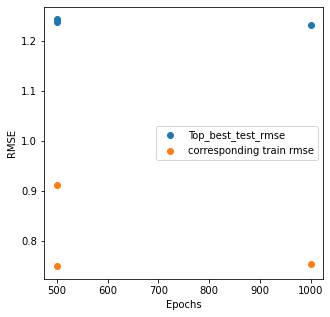

In [296]:
plt.figure(figsize=(5,5))
plt.scatter(results_sorted['n_epochs'], results_sorted['best_test_test_rmse'],label = 'Top_best_test_rmse')
plt.scatter(results_sorted['n_epochs'], results_sorted['best_test_train_rmse'],label = 'corresponding train rmse')
plt.legend()
plt.xlabel(f'Epochs')
plt.ylabel('RMSE')

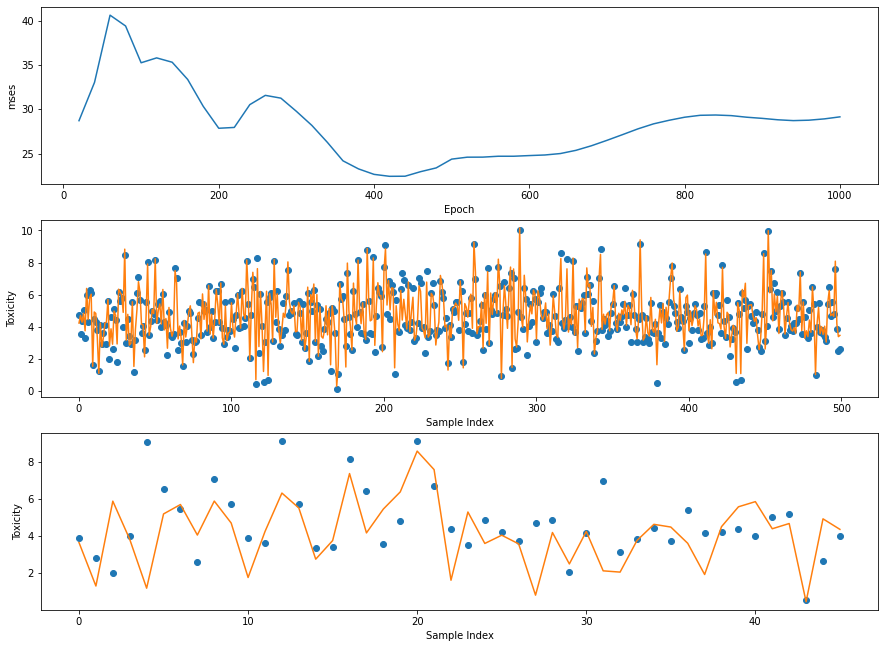

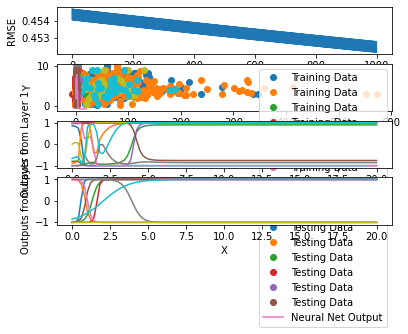

In [334]:
data = run_data(Xtrain, Ttrain,Xtest,Ttest, 1000,20,[10,10],method='sgd',learning_rate=0.1,plot=True)


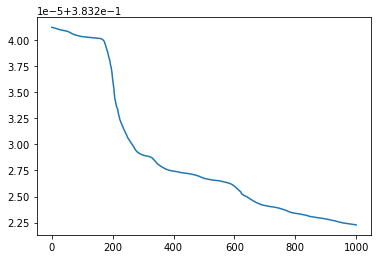

In [335]:
plt.plot(nnet.get_error_trace())

## Test for ADAM



In [303]:
results_adam = []
epochs =[500,750,1000]
hidden_list = [[10],[10,10]]
learning_rates =[0.1,0.01,0.001] 
for epoch in epochs:
    for hiddens in hidden_list:
        for learning in learning_rates:
            nnet,n_epochs,learning_rate,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse = run_data(Xtrain, Ttrain,Xtest,Ttest, epoch,20,hiddens,method='adam',learning_rate=learning,plot=False)
            results_adam += [(nnet,n_epochs,learning_rate,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse)]



Best test error is at epoch 40.0 with RMSE Train of 0.76 and Test of 1.46
Best test error is at epoch 60.0 with RMSE Train of 0.74 and Test of 1.33
Best test error is at epoch 120.0 with RMSE Train of 0.79 and Test of 1.25
Best test error is at epoch 320.0 with RMSE Train of 0.46 and Test of 1.35
Best test error is at epoch 20.0 with RMSE Train of 0.62 and Test of 1.64
Best test error is at epoch 40.0 with RMSE Train of 0.83 and Test of 1.31
Best test error is at epoch 20.0 with RMSE Train of 0.72 and Test of 1.54
Best test error is at epoch 60.0 with RMSE Train of 0.71 and Test of 1.34
Best test error is at epoch 40.0 with RMSE Train of 0.87 and Test of 1.23
Best test error is at epoch 100.0 with RMSE Train of 0.53 and Test of 1.42
Best test error is at epoch 20.0 with RMSE Train of 0.60 and Test of 1.41
Best test error is at epoch 20.0 with RMSE Train of 0.93 and Test of 1.41
Best test error is at epoch 120.0 with RMSE Train of 0.71 and Test of 1.26
Best test error is at epoch 20.0 w

In [304]:
results_adam = np.array(results_adam)
cols =['n_epochs','learning_rate','rmses','mses', 'best_test_epoch', 'best_test_train_rmse', "best_test_test_rmse"] 
results_df_adam = pd.DataFrame(results_adam[:,1:],index = results_adam[:,0],columns=cols)
results_df_adam

,n_epochs,learning_rate,rmses,mses,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10], 1)",500,0.1,"[[20.0, 0.7779271240247126, 1.4646728573965553...","[[20.0, 23.968988993464183], [40.0, 23.5068605...",40,0.761942,1.45985
"NeuralNetwork(8, [10], 1)",500,0.01,"[[20.0, 0.7900390431443786, 1.3747241480301031...","[[20.0, 35.20045444365667], [40.0, 29.39504062...",60,0.736908,1.33034
"NeuralNetwork(8, [10], 1)",500,0.001,"[[20.0, 1.1015944396301194, 1.4528420164010587...","[[20.0, 22.665490867983262], [40.0, 12.4142336...",120,0.785382,1.25112
"NeuralNetwork(8, [10, 10], 1)",500,0.1,"[[20.0, 0.467636142118631, 1.5966393729054562]...","[[20.0, 31.93950352979652], [40.0, 33.30277016...",320,0.455713,1.35455
"NeuralNetwork(8, [10, 10], 1)",500,0.01,"[[20.0, 0.6183260275474528, 1.6377422529040349...","[[20.0, 45.042980578660995], [40.0, 34.7828827...",20,0.618326,1.63774
"NeuralNetwork(8, [10, 10], 1)",500,0.001,"[[20.0, 1.0957051078957383, 1.451237367018342]...","[[20.0, 22.161957870286603], [40.0, 27.6543639...",40,0.825551,1.30584
"NeuralNetwork(8, [10], 1)",750,0.1,"[[20.0, 0.721545929424676, 1.5429414618079853]...","[[20.0, 14.777021998239414], [40.0, 14.9447199...",20,0.721546,1.54294
"NeuralNetwork(8, [10], 1)",750,0.01,"[[20.0, 0.7737045495268632, 1.401449214578851]...","[[20.0, 40.8143155728037], [40.0, 34.764614734...",60,0.707454,1.33768
"NeuralNetwork(8, [10], 1)",750,0.001,"[[20.0, 1.080181766865414, 1.4019715017798855]...","[[20.0, 21.006307635266275], [40.0, 21.1845772...",40,0.873593,1.2331
"NeuralNetwork(8, [10, 10], 1)",750,0.1,"[[20.0, 0.5119161213138687, 1.571202188133688]...","[[20.0, 24.512332861989634], [40.0, 24.8327291...",100,0.530062,1.42236


In [305]:
results_sorted_adam =results_df_adam[['n_epochs','learning_rate','best_test_epoch', 'best_test_train_rmse', 'best_test_test_rmse']]

results_sorted_adam = results_sorted_adam.sort_values(by=['best_test_test_rmse']).head(3)


results_sorted_adam

,n_epochs,learning_rate,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10], 1)",750,0.001,40,0.873593,1.2331
"NeuralNetwork(8, [10], 1)",500,0.001,120,0.785382,1.25112
"NeuralNetwork(8, [10], 1)",1000,0.1,120,0.707732,1.25936


Text(0, 0.5, 'RMSE')

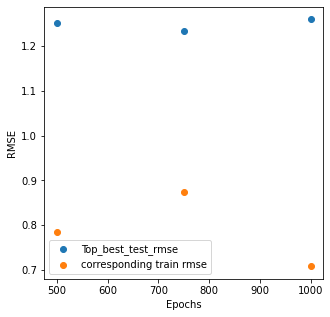

In [306]:
plt.figure(figsize=(5,5))
plt.scatter(results_sorted_adam['n_epochs'], results_sorted_adam['best_test_test_rmse'],label = 'Top_best_test_rmse')
plt.scatter(results_sorted_adam['n_epochs'], results_sorted_adam['best_test_train_rmse'],label = 'corresponding train rmse')
plt.legend()
plt.xlabel(f'Epochs')
plt.ylabel('RMSE')

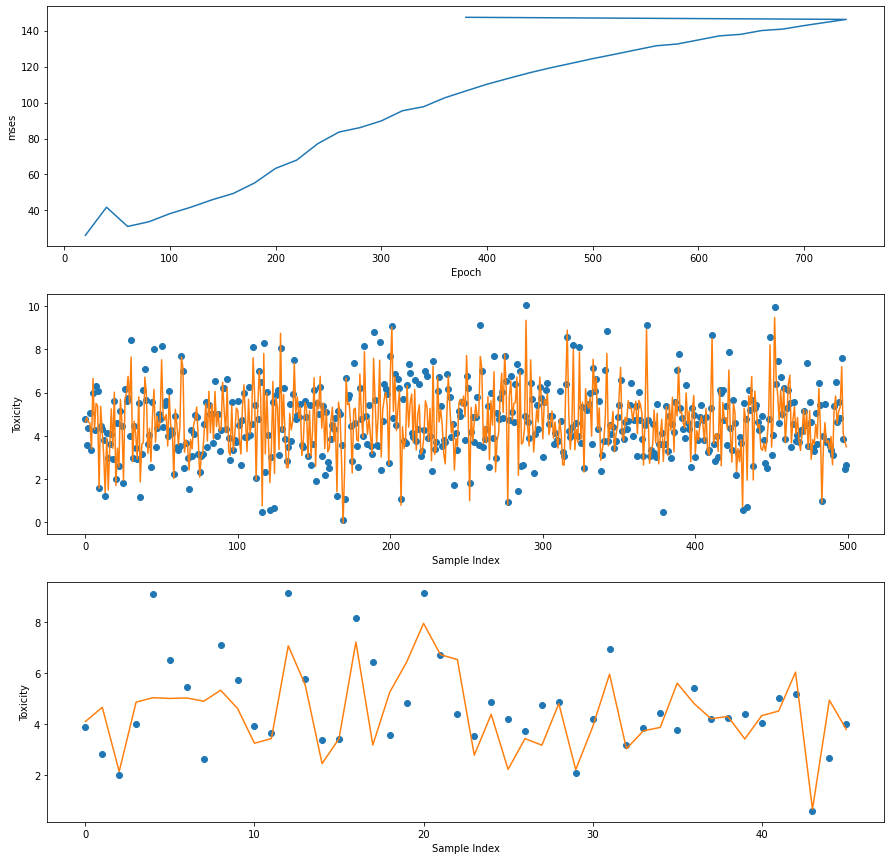

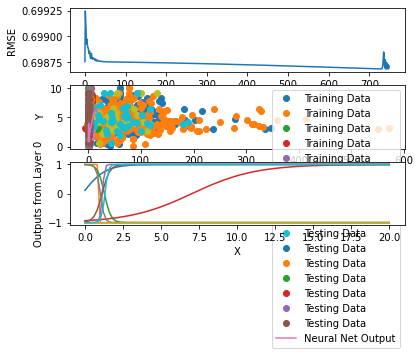

In [336]:
data = run_data(Xtrain, Ttrain,Xtest,Ttest, 750,20,[10],method='adam',learning_rate=0.001,plot=True)

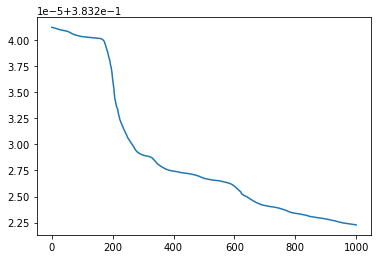

In [337]:
plt.plot(nnet.get_error_trace())

In [338]:
def run_scg(Xtrain, Ttrain, Xtest, Ttest,n_epochs, n_epochs_per_train, n_hiddens_list,method, learning_rate=None,plot=False):
    
    n_reps = n_epochs // n_epochs_per_train

    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1
        
    n_inputs = Xtrain.shape[1]
    n_hiddens_list = n_hiddens_list
    n_outputs = Ttrain.shape[1]
    
    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    

    rmses = []
    mses = []
    train_accuracy =[] 
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)
        def rmse(Y, T):
            error = T - Y
            return np.sqrt(np.mean(error ** 2))
    
        rmses.append([(reps + 1) * n_epoch,
                      rmse(nnet.use(Xtrain), Ttrain),
                      rmse(nnet.use(Xtest), Ttest)])
        mses.append([(reps+1)*n_epoch,nnet.mse(Xtrain,Ttrain)])

        
    rmses = np.array(rmses)
    mses = np.array(mses)
  
    best_test_index = np.argmin(rmses[:, -1])
    best_test_epoch, best_test_train_rmse, best_test_test_rmse = rmses[best_test_index, :]
    
    if(plot==True):
        
        plt.figure(1, figsize=(20, 20))
        plt.clf()

        n_plot_rows = nnet.n_layers + 1
        ploti = 0



        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(mses[:, 0], mses[:, 1], label='mses')
        plt.xlabel('Epoch')
        plt.ylabel('mses')

        ploti += 1    
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttrain,'o',label='Ttrain')
        plt.plot(nnet.use(Xtrain),label= 'Predicted Test')
        plt.xlabel('Sample Index')
        plt.ylabel('Toxicity')

        ploti += 1    
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttest,'o',label='Ttest')
        plt.plot(nnet.use(Xtest),label= 'Predicted Test')

        plt.xlabel('Sample Index')
        plt.ylabel('Toxicity')

        plt.figure(2)
        plt.plot(rmses[:, 0], rmses[:, 1], label='Train')
        plt.plot(rmses[:, 0], rmses[:, 2], label='Test')
        plt.legend()
        ymin, ymax = plt.ylim()
        plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
        plt.xlabel(f'Epochs')
        plt.ylabel('RMSE')
    
        plt.figure(2, figsize=(30, 30))
        plt.clf()

        n_plot_rows2 = nnet.n_layers + 1
        plot2i = 0

        plot2i += 1
        plt.subplot(n_plot_rows2, 1, plot2i)
        plt.plot(nnet.get_error_trace())
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')

        plot2i += 1
        plt.subplot(n_plot_rows2, 1, plot2i)
        plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
        plt.plot(Xtest, Ttest, 'o', label='Testing Data')
        X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
        Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
        plt.plot(X_for_plot, Y, label='Neural Net Output')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')

        for layeri in range(nnet.n_layers - 2, -1, -1):
            plot2i += 1
            plt.subplot(n_plot_rows2, 1, plot2i)
            plt.plot(X_for_plot, Zs[layeri])
            plt.xlabel('X')
            plt.ylabel(f'Outputs from Layer {layeri}')
    else:
        print(f'Best test error is at epoch {best_test_epoch}', end='')
        print(f' with RMSE Train of {best_test_train_rmse:.2f} and Test of {best_test_test_rmse:.2f}')

    return nnet,n_epochs,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse

In [314]:
results_scg = []
epochs =[500,750,1000]
hidden_list = [[10],[10,10]]

for epoch in epochs:
    for hiddens in hidden_list:
        nnet,n_epochs,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse = run_scg(Xtrain, Ttrain,Xtest,Ttest, epoch,20,hiddens,method='scg',plot=False)
        results_scg += [(nnet,n_epochs,rmses,mses, best_test_epoch, best_test_train_rmse, best_test_test_rmse)]



Best test error is at epoch 500.0 with RMSE Train of 0.67 and Test of 1.43
Best test error is at epoch 20.0 with RMSE Train of 0.54 and Test of 1.91
Best test error is at epoch 360.0 with RMSE Train of 0.68 and Test of 1.50
Best test error is at epoch 20.0 with RMSE Train of 0.47 and Test of 2.06
Best test error is at epoch 1000.0 with RMSE Train of 0.69 and Test of 1.56
Best test error is at epoch 20.0 with RMSE Train of 0.44 and Test of 2.36


In [316]:
results_scg = np.array(results_scg)
cols =['n_epochs','rmses','mses', 'best_test_epoch', 'best_test_train_rmse', "best_test_test_rmse"] 
results_df_scg = pd.DataFrame(results_scg[:,1:],index = results_scg[:,0],columns=cols)
results_df_scg

,n_epochs,rmses,mses,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10], 1)",500,"[[20.0, 0.7575220274707042, 1.5013013984819201...","[[20.0, 21.39442120297115], [40.0, 17.74902707...",500,0.671711,1.42825
"NeuralNetwork(8, [10, 10], 1)",500,"[[20.0, 0.5378809762829602, 1.9081247393649432...","[[20.0, 39.20893012192401], [40.0, 21.61969006...",20,0.537881,1.90812
"NeuralNetwork(8, [10], 1)",750,"[[20.0, 0.7107114807218632, 1.617224120201533]...","[[20.0, 28.82365322287351], [40.0, 27.44362259...",360,0.679798,1.5042
"NeuralNetwork(8, [10, 10], 1)",750,"[[20.0, 0.47130562440376395, 2.061788096309303...","[[20.0, 28.514647029260946], [40.0, 26.4123830...",20,0.471306,2.06179
"NeuralNetwork(8, [10], 1)",1000,"[[20.0, 0.7247648593817235, 1.5798387185669451...","[[20.0, 29.71946103998116], [40.0, 29.99640718...",1000,0.689654,1.56071
"NeuralNetwork(8, [10, 10], 1)",1000,"[[20.0, 0.44370853959208006, 2.358465806267109...","[[20.0, 20.368666673129336], [40.0, 25.1927421...",20,0.443709,2.35847


In [318]:
results_sorted_scg =results_df_scg[['n_epochs','best_test_epoch', 'best_test_train_rmse', 'best_test_test_rmse']]

results_sorted_scg = results_sorted_scg.sort_values(by=['best_test_test_rmse']).head(3)


results_sorted_scg

,n_epochs,best_test_epoch,best_test_train_rmse,best_test_test_rmse
"NeuralNetwork(8, [10], 1)",500,500,0.671711,1.42825
"NeuralNetwork(8, [10], 1)",750,360,0.679798,1.5042
"NeuralNetwork(8, [10], 1)",1000,1000,0.689654,1.56071


Text(0, 0.5, 'RMSE')

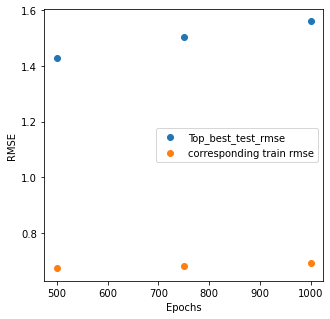

In [319]:
plt.figure(figsize=(5,5))
plt.scatter(results_sorted_scg['n_epochs'], results_sorted_scg['best_test_test_rmse'],label = 'Top_best_test_rmse')
plt.scatter(results_sorted_scg['n_epochs'], results_sorted_scg['best_test_train_rmse'],label = 'corresponding train rmse')
plt.legend()
plt.xlabel(f'Epochs')
plt.ylabel('RMSE')

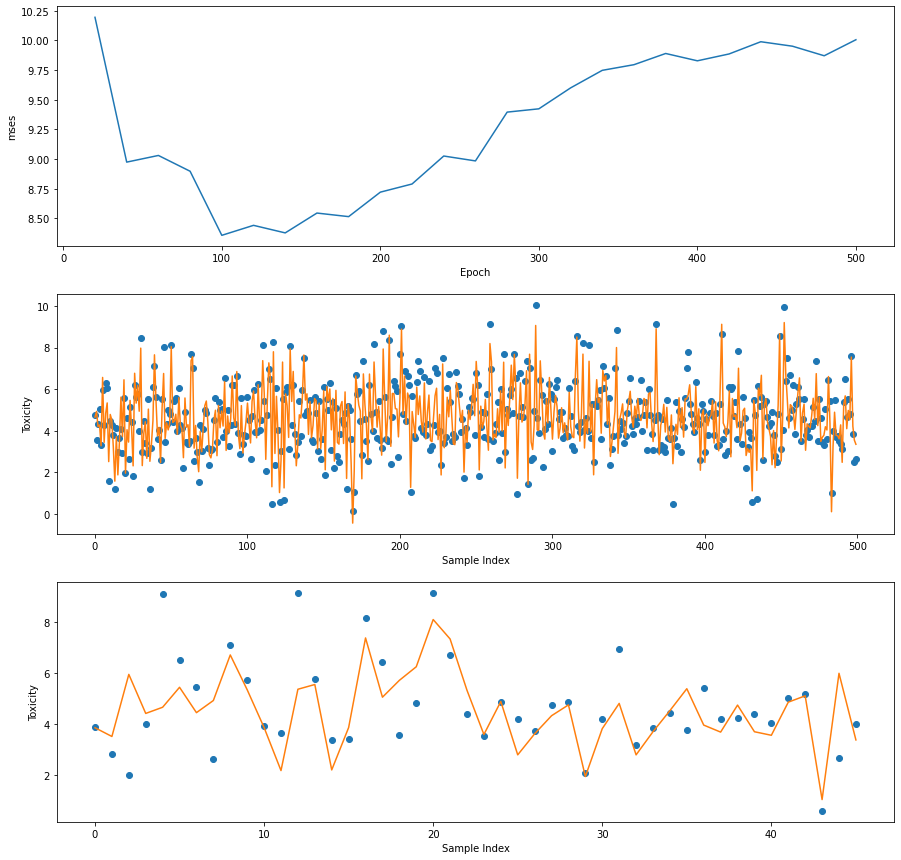

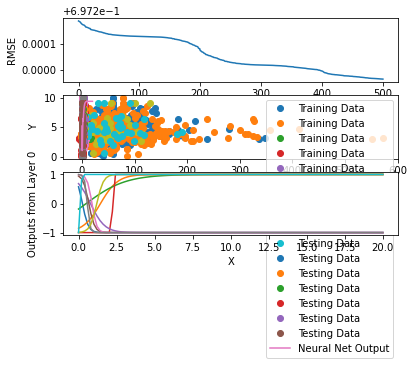

In [339]:
data = run_data(Xtrain, Ttrain,Xtest,Ttest, 500,20,[10],method='scg',plot=True)

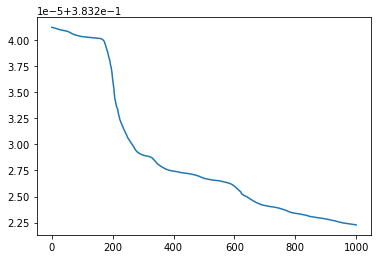

In [340]:
plt.plot(nnet.get_error_trace())

## Observation


1. I used the traditional learning rate range of 0.1 to 0.01 on all the three methods.
2. For SGD we can observer for the above graph that the training cruve for the given best rsme shows that the curve fits almost all the data from training even thou in test it misses most of the data.
3. This could be an effet on overfitting which is due to the number of epochs trained. It can also be a cause of the hidden units and improper learning rates.
4. Even thou i have ran 27 combinations it doesnot go well with these combination may be switching to an higher hiddens and increasing the learning rate and epochs can work. 
5. With thegiven epochs and n_hidden we can observe that adam performs very poorly which means that the data is underfitting.
6. This is a general characteristic of adam and this can be overcome by using proper learning rates. 
7. Adam performs better on some data that other. 
8. Here we can clearly see that sgd performs better than adam. 
9. Scg has the worst performance  which is strange as in the lesson i noticed scg was performing better than adam 
10. The Sgd give lesser Rmse error and better performance. 
11. Sgd in general is used inmost cases for this type of dataset even RMSprop has similar performance in regression dataset. Adam performes better on categorical dataset. 
12. Scg was a new type of optimizer for me and would like to explore more into it as i would like to see it level of performance on various data. 

# Extra Credit

Earn one extra credit point by downloading a second, real data set and repeating the above experiments.

In [341]:
df = pd.read_csv('auto-mpg.data', header=None, delim_whitespace=True, na_values='?')


In [342]:
names =  ['mpg','cylinders','displacement','horsepower','weight',
          'acceleration','year','origin', 'model']

In [343]:
df.columns = names


In [344]:
df.isna().sum()


mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
model           0
dtype: int64

In [345]:
df = df.dropna()
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
model           0
dtype: int64

In [348]:
data = df.iloc[:,:-1].values


In [352]:
data_numpy=df.to_numpy()

In [353]:
data_numpy

array([[18.0, 8, 307.0, ..., 70, 1, 'chevrolet chevelle malibu'],
       [15.0, 8, 350.0, ..., 70, 1, 'buick skylark 320'],
       [18.0, 8, 318.0, ..., 70, 1, 'plymouth satellite'],
       ...,
       [32.0, 4, 135.0, ..., 82, 1, 'dodge rampage'],
       [28.0, 4, 120.0, ..., 82, 1, 'ford ranger'],
       [31.0, 4, 119.0, ..., 82, 1, 'chevy s-10']], dtype=object)

In [362]:
data_numpy.shape

(392, 9)

In [357]:
np.random.shuffle(data_numpy)

train_data= data_numpy[:300]
test_data = data_numpy[92:]

In [368]:
Xtrain = train_data[:, :-1]
Ttrain = train_data[:, -1:]
Xtest = test_data[:, :-1]
Ttest = test_data[:, -1:]

Xtrain =Xtrain.astype(float)
Ttrain= Ttrain
Xtest=Xtest.astype(float)
Ttest= Ttest



In [369]:
data = run_data(Xtrain, Ttrain,Xtest,Ttest, 750,20,[10],method='adam',learning_rate=0.001,plot=True)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [355]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Balasubramaniam-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[1

# Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A3.ipynb```.  So, for me it would be ```Anderson-A3.ipynb```.  Submit the file using the ```Assignment 3``` link on [Canvas](https://colostate.instructure.com/courses/109894).